# 03 — Decision Tree Model  
Hotel Booking Demand (Cancellation Prediction)

## Notebook purpose
This notebook develops a strong supervised baseline using **Decision Tree** and demonstrates:
- leakage-safe end-to-end modeling using `sklearn.Pipeline` (`preprocessing → model`)
- hyperparameter tuning using stratified cross-validation
- test-set evaluation using multiple metrics and diagnostic plots
- interpretability using coefficient analysis on transformed features

## Inputs
- Preferred: `data/processed/hotel_bookings_dedup.csv`
- Fallback: `data/raw/hotel_bookings.csv`

## Outputs (overwritten on each run)
- Model:
  - `artifacts/models/dt_pipeline.joblib`
- Metrics:
  - `artifacts/metrics/dt_cv_results.csv`
  - `artifacts/metrics/dt_best_params.json`
  - `artifacts/metrics/dt_test_metrics.json`
  - `artifacts/metrics/dt_threshold_metrics.csv`
  - `artifacts/metrics/dt_coefficients_top.csv`
- Plots:
  - `artifacts/plots/dt_confusion_matrix.png`
  - `artifacts/plots/dt_roc_curve.png`
  - `artifacts/plots/dt_pr_curve.png`
  - `artifacts/plots/dt_feature_importance.png`
  - `artifacts/plots/dt_tree_depth_vs_f1.png`
- Reports:
  - `artifacts/reports/dt_classification_report.txt`
  - `artifacts/reports/dt_notes.md`
  - `artifacts/reports/run_metadata.json`

All preprocessing steps are fitted on training folds only (no leakage).


## Working directory

In [1]:
# Repository bootstrap (fixes ModuleNotFoundError: 'src')
# The repository root is resolved quickly using Git when available.
# A bounded parent-directory scan is used as a fallback.

import os
import sys
import subprocess
from pathlib import Path

def _find_repo_root(max_levels: int = 25) -> Path:
    try:
        out = subprocess.check_output(
            ["git", "rev-parse", "--show-toplevel"],
            stderr=subprocess.DEVNULL,
            text=True,
        ).strip()
        p = Path(out)
        if (p / "src").is_dir():
            return p
    except Exception:
        pass

    cwd = Path.cwd()
    for p in [cwd] + list(cwd.parents)[:max_levels]:
        if (p / "src").is_dir():
            return p

    raise FileNotFoundError(
        "Folder 'src' was not found within the parent directories. "
        "Open the repository root folder in VS Code and rerun the notebook."
    )

root = _find_repo_root(max_levels=25)
os.chdir(root)
if str(root) not in sys.path:
    sys.path.insert(0, str(root))

print("Working directory:", Path.cwd())
print("Python path entry added:", root)


Working directory: D:\Documents\SLIIT_Campus\Y4S2\ML_IT4060\ML_assignment_01\Machine-Learning-Assignment
Python path entry added: D:\Documents\SLIIT_Campus\Y4S2\ML_IT4060\ML_assignment_01\Machine-Learning-Assignment


## Imports and configuration fallback

`src.config` may differ between group members during active development.
To prevent notebook failures, configuration values are loaded with safe fallbacks.


In [2]:
# Imports, config, artifacts

import json
import platform
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.io_utils import (
    ensure_artifact_dirs,
    save_json,
    save_text,
    save_dataframe,
    save_model,
    save_run_metadata,
)
from src.data_loader import load_hotel_bookings, basic_train_ready_checks
from src.preprocessing import build_preprocessor, PreprocessOptions, get_feature_names
from src.metrics import compute_classification_metrics
from src.train_eval import (
    split_xy,
    make_train_test_split as train_test_split,
    get_estimator,
    build_model_pipeline,
    tune_with_gridsearch,
    evaluate_on_test,
    TrainOptions,
)
from src.plots import (
    plot_confusion_matrix,
    plot_roc_curve,
    plot_pr_curve,
    plot_feature_importance,
)
import src.config as cfg

warnings.filterwarnings("ignore", category=UserWarning)

PROJECT_NAME = getattr(cfg, "PROJECT_NAME", "ML-assignment")
RANDOM_STATE = int(getattr(cfg, "RANDOM_STATE", 42))
TARGET_COL = getattr(cfg, "TARGET_COL", "is_canceled")
TEST_SIZE = float(getattr(cfg, "TEST_SIZE", 0.20))
CV_SPLITS = int(getattr(cfg, "CV_SPLITS", 5))
LEAKAGE_COLS = list(
    getattr(cfg, "LEAKAGE_COLS", ["reservation_status", "reservation_status_date"])
)
DEFAULT_DATA_PATH = str(getattr(cfg, "DEFAULT_DATA_PATH", "data/raw/hotel_bookings.csv"))
FORCE_CATEGORICAL_COLS = list(getattr(cfg, "FORCE_CATEGORICAL_COLS", ["agent", "company"]))
ONEHOT_MIN_FREQUENCY = getattr(cfg, "ONEHOT_MIN_FREQUENCY", 0.01)
PARAM_GRIDS = getattr(cfg, "PARAM_GRIDS", {}) or {}
FIG_DPI = getattr(cfg, "FIG_DPI", 160)

MODEL_NAME = "dt"  # decision tree short name

ART = ensure_artifact_dirs("artifacts")

meta_path = save_run_metadata(
    {
        "project": PROJECT_NAME,
        "random_state": RANDOM_STATE,
        "test_size": TEST_SIZE,
        "cv_splits": CV_SPLITS,
        "target_col": TARGET_COL,
        "notebook": "05_model_decision_tree.ipynb",
        "python_version": sys.version,
        "platform": platform.platform(),
    },
    base_dir="artifacts",
    repo_root=".",
)
print("Metadata file:", meta_path.resolve())
print("Artifacts base:", ART["base"].resolve())

display(
    pd.DataFrame(
        [
            {
                "PROJECT_NAME": PROJECT_NAME,
                "RANDOM_STATE": RANDOM_STATE,
                "TEST_SIZE": TEST_SIZE,
                "CV_SPLITS": CV_SPLITS,
                "TARGET_COL": TARGET_COL,
                "ONEHOT_MIN_FREQUENCY": ONEHOT_MIN_FREQUENCY,
                "LEAKAGE_COLS": ", ".join(LEAKAGE_COLS),
                "FORCE_CATEGORICAL_COLS": ", ".join(FORCE_CATEGORICAL_COLS),
            }
        ]
    )
)

# Reduce warning noise during cross-validation
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message=r".*'penalty' was deprecated.*",
)


Metadata file: D:\Documents\SLIIT_Campus\Y4S2\ML_IT4060\ML_assignment_01\Machine-Learning-Assignment\artifacts\reports\run_metadata.json
Artifacts base: D:\Documents\SLIIT_Campus\Y4S2\ML_IT4060\ML_assignment_01\Machine-Learning-Assignment\artifacts


,PROJECT_NAME,RANDOM_STATE,TEST_SIZE,CV_SPLITS,TARGET_COL,ONEHOT_MIN_FREQUENCY,LEAKAGE_COLS,FORCE_CATEGORICAL_COLS
0,ML-assignment,42,0.2,5,is_canceled,0.01,"reservation_status, reservation_status_date","agent, company"


## Dataset loading

The processed dataset is preferred when available to standardize rows across the team.


In [3]:
# Dataset loading (prefer processed, fallback to raw)


preferred_processed = Path("data/processed/hotel_bookings_dedup.csv")
preferred_raw = Path(DEFAULT_DATA_PATH)

dataset_path = preferred_processed if preferred_processed.exists() else preferred_raw
if not dataset_path.exists():
    raise FileNotFoundError("Dataset not found. Expected at data/raw/hotel_bookings.csv")

print("Dataset path:", dataset_path.resolve())

df = load_hotel_bookings(dataset_path, drop_duplicates=False, verbose=True)
basic_train_ready_checks(df, target_col=TARGET_COL)

display(df.head())
display(pd.DataFrame({"rows": [df.shape[0]], "columns": [df.shape[1]]}))


Dataset path: D:\Documents\SLIIT_Campus\Y4S2\ML_IT4060\ML_assignment_01\Machine-Learning-Assignment\data\processed\hotel_bookings_dedup.csv
[data_loader] Loaded shape: (87396, 32)
[data_loader] Columns: 32


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


,rows,columns
0,87396,32


## Type safety for identifier-like columns

Columns such as `agent` and `company` represent identifiers.
Casting them to string avoids implying a numeric ordering and supports one-hot encoding.


In [4]:
# Cast identifier-like numeric columns to strings to avoid ordinal meaning


df_model = df.copy()
converted = []
for c in FORCE_CATEGORICAL_COLS:
    if c in df_model.columns:
        # Preserve missingness explicitly as a category label
        df_model[c] = pd.to_numeric(df_model[c], errors="coerce").astype("Int64").astype("string")
        df_model[c] = df_model[c].fillna("MISSING")
        converted.append(c)

display(pd.DataFrame({"converted_to_string": converted}))
if converted:
    display(df_model[converted].head())


,converted_to_string
0,agent
1,company


,agent,company
0,MISSING,MISSING
1,MISSING,MISSING
2,MISSING,MISSING
3,304,MISSING
4,240,MISSING


## Train/test split

A stratified split preserves cancellation rate in both partitions.
Split metadata and label distributions are displayed and saved.


In [5]:
# Stratified train/test split

from sklearn.model_selection import train_test_split


X = df_model.drop(columns=[TARGET_COL])
y = df_model[TARGET_COL].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y,
)

split_info = {
    "n_rows_total": int(len(df_model)),
    "n_train": int(len(X_train)),
    "n_test": int(len(X_test)),
    "test_size": float(TEST_SIZE),
    "random_state": int(RANDOM_STATE),
    "stratified": True,
}
# save_json(split_info, ART["data"] / "train_test_split_dt.json")
save_json(split_info, ART["data"] / f"train_test_split_{MODEL_NAME}.json")

train_dist = y_train.value_counts().rename_axis("label").reset_index(name="count")
train_dist["rate"] = train_dist["count"] / train_dist["count"].sum()

test_dist = y_test.value_counts().rename_axis("label").reset_index(name="count")
test_dist["rate"] = test_dist["count"] / test_dist["count"].sum()

display(pd.DataFrame([split_info]))
display(train_dist)
display(test_dist)

# print("Saved:", (ART["data"] / "train_test_split_dt.json").resolve())
print("Saved:", (ART["data"] / f"train_test_split_{MODEL_NAME}.json").resolve())


,n_rows_total,n_train,n_test,test_size,random_state,stratified
0,87396,69916,17480,0.2,42,True


,label,count,rate
0,0,50696,0.725099
1,1,19220,0.274901


,label,count,rate
0,0,12675,0.725114
1,1,4805,0.274886


Saved: D:\Documents\SLIIT_Campus\Y4S2\ML_IT4060\ML_assignment_01\Machine-Learning-Assignment\artifacts\data\train_test_split_dt.json


## Build preprocessors and model pipeline

In [6]:
# Build preprocessors and model pipeline

preprocess_opts = PreprocessOptions(
    onehot_min_frequency=ONEHOT_MIN_FREQUENCY,
    output_sparse=True,
    scale_numeric=True,
)
preprocess = build_preprocessor(
    drop_cols=LEAKAGE_COLS,
    force_categorical_cols=FORCE_CATEGORICAL_COLS,
    options=preprocess_opts,
)

estimator = get_estimator("decision_tree", random_state=RANDOM_STATE)
pipeline = build_model_pipeline(preprocess, estimator)

pipeline

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('features', ...), ('transform', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,drop_cols,"['reservation_status', 'reservation_status_date']"
,force_categorical_cols,"['agent', 'company']"
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer an

## Define a reasonable hyperparameter grid

In [7]:
# Hyperparameter grid + cross-validated grid search

param_grid = PARAM_GRIDS.get(
    "decision_tree",
    {
        "model__max_depth": [None, 5, 10, 20],
        "model__min_samples_split": [2, 10, 30],
        "model__min_samples_leaf": [1, 5, 10],
        "model__class_weight": [None, "balanced"],
    },
)


# Hyperparameter Grid search CV
cv_options = TrainOptions(
    random_state=RANDOM_STATE,
    cv_splits=CV_SPLITS,
    scoring="f1",
    n_jobs=-1,
    verbose=2,
)
search = tune_with_gridsearch(
    pipeline=pipeline,
    param_grid=param_grid,
    X_train=X_train,
    y_train=y_train,
    options=cv_options,
)


# Save CV results and best params
cv_results_df = pd.DataFrame(search.cv_results_)
save_dataframe(cv_results_df, ART["metrics"] / f"{MODEL_NAME}_cv_results.csv", index=False)
save_json(search.best_params_, ART["metrics"] / f"{MODEL_NAME}_best_params.json")

best_model = search.best_estimator_
print("Best params:", search.best_params_)
print("Best CV F1:", search.best_score_)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best params: {'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__min_samples_leaf': 10, 'model__min_samples_split': 30}
Best CV F1: 0.6842992298545589


## Extra prat

In [8]:
# import sklearn
# from packaging.version import Version
# from sklearn.model_selection import StratifiedKFold, ParameterGrid
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import f1_score
# from tqdm.auto import tqdm

# sk_ver = Version(sklearn.__version__)
# print("scikit-learn version:", sklearn.__version__)

# # Default DT grid (used if config has no decision_tree grid)
# default_grid = {
#     "model__max_depth": [None, 5, 10, 20],
#     "model__min_samples_split": [2, 10, 30],
#     "model__min_samples_leaf": [1, 5, 10],
#     "model__class_weight": [None, "balanced"],
# }

# # Use config grid if defined; otherwise fallback to default
# param_grid = PARAM_GRIDS.get("decision_tree", default_grid)
# grid = list(ParameterGrid(param_grid))

# display(pd.DataFrame(grid).head(15))
# print("Parameter combinations:", len(grid))

# cv = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# def make_fresh_pipeline() -> Pipeline:
#     """Create a fresh preprocessing→model pipeline for each fit (clone-safe)."""
#     preprocess = build_preprocessor(
#         drop_cols=LEAKAGE_COLS,
#         force_categorical_cols=FORCE_CATEGORICAL_COLS,
#         options=PreprocessOptions(
#             onehot_min_frequency=ONEHOT_MIN_FREQUENCY,
#             output_sparse=True,
#             scale_numeric=True,
#         ),
#     )
#     dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
#     return Pipeline([("preprocess", preprocess), ("model", dt)])

# results = []
# best_so_far = -1.0
# best_params = None

# total_fits = len(grid) * CV_SPLITS
# pbar = tqdm(total=total_fits, desc="DecisionTree CV fits", leave=True)

# for params in grid:
#     fold_scores = []
#     for tr_idx, va_idx in cv.split(X_train, y_train):
#         m = make_fresh_pipeline()
#         m.set_params(**params)
#         m.fit(X_train.iloc[tr_idx], y_train.iloc[tr_idx])
#         pred = m.predict(X_train.iloc[va_idx])
#         fold_scores.append(f1_score(y_train.iloc[va_idx], pred, zero_division=0))
#         pbar.update(1)

#     mean_f1 = float(np.mean(fold_scores))
#     std_f1 = float(np.std(fold_scores))

#     if mean_f1 > best_so_far:
#         best_so_far = mean_f1
#         best_params = dict(params)

#     status = {
#         "best_f1": f"{best_so_far:.4f}",
#         "curr_f1": f"{mean_f1:.4f}",
#         "max_depth": params.get("model__max_depth", ""),
#         "min_split": params.get("model__min_samples_split", ""),
#         "min_leaf": params.get("model__min_samples_leaf", ""),
#         "cw": params.get("model__class_weight", ""),
#     }
#     pbar.set_postfix(status)

#     results.append({
#         **params,
#         "cv_f1_mean": mean_f1,
#         "cv_f1_std": std_f1,
#         "cv_f1_scores": [float(x) for x in fold_scores],
#     })

# pbar.close()

# # Results table, sorted
# cv_results = pd.DataFrame(results).sort_values("cv_f1_mean", ascending=False).reset_index(drop=True)

# # Persist results (scores column dropped for CSV brevity)
# save_dataframe(cv_results.drop(columns=["cv_f1_scores"]), ART["metrics"] / "dt_cv_results.csv", index=False)
# save_json(best_params, ART["metrics"] / "dt_best_params.json")

# print("Saved:", (ART["metrics"] / "dt_cv_results.csv").resolve())
# print("Best params:", best_params)

# display(cv_results.head(15))

# # Fit best model on full train
# best_model = make_fresh_pipeline()
# best_model.set_params(**best_params)
# best_model.fit(X_train, y_train)

## Test-set evaluation

Multiple metrics are computed and saved:
- Accuracy and Balanced Accuracy
- Precision, Recall, F1
- ROC-AUC and PR-AUC (probability-based)
- Log loss (probability calibration check)
- Confusion matrix

Probability-based metrics are computed only when `predict_proba` is available.

In [9]:
# Test-set evaluation

from sklearn.metrics import classification_report, confusion_matrix

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

test_metrics = compute_classification_metrics(y_test, y_pred, y_proba=y_proba)
save_json(test_metrics, ART["metrics"] / f"{MODEL_NAME}_test_metrics.json")

# # Add confusion matrix as nested list
# cm = confusion_matrix(y_test, y_pred)
# test_metrics["confusion_matrix"] = cm.tolist()

save_json(test_metrics, ART["metrics"] / f"{MODEL_NAME}_test_metrics.json")

# Display computed metrics
print("=" * 50)
print("TEST SET EVALUATION METRICS")
print("=" * 50)
print(f"Accuracy:          {test_metrics.get('accuracy', 'N/A'):.4f}")
print(f"Balanced Accuracy: {test_metrics.get('balanced_accuracy', 'N/A'):.4f}")
print("-" * 50)
print(f"Precision:         {test_metrics.get('precision', 'N/A'):.4f}")
print(f"Recall:            {test_metrics.get('recall', 'N/A'):.4f}")
print(f"F1 Score:          {test_metrics.get('f1', 'N/A'):.4f}")
print("-" * 50)
if y_proba is not None:
    print(f"ROC-AUC:           {test_metrics.get('roc_auc', 'N/A'):.4f}")
    print(f"PR-AUC:            {test_metrics.get('pr_auc', 'N/A'):.4f}")
    print(f"Log Loss:          {test_metrics.get('log_loss', 'N/A'):.4f}")
print("=" * 50)


# Display as DataFrame for better visualization
display(pd.DataFrame([test_metrics]).T.rename(columns={0: "Value"}))


TEST SET EVALUATION METRICS
Accuracy:          0.7907
Balanced Accuracy: 0.8013
--------------------------------------------------
Precision:         0.5845
Recall:            0.8248
F1 Score:          0.6842
--------------------------------------------------
ROC-AUC:           0.8751
PR-AUC:            0.7281
Log Loss:          1.0365


,Value
accuracy,0.790675
balanced_accuracy,0.801259
precision,0.584513
recall,0.824766
f1,0.684161
confusion_matrix,"[[9858, 2817], [842, 3963]]"
roc_auc,0.875145
pr_auc,0.728146
log_loss,1.036469


## Classification report
The full classification report is saved for submission and also displayed inline.


In [10]:
# Classification report (display and save)
clf_report = classification_report(y_test, y_pred, digits=3)
save_text(clf_report, ART["reports"] / f"{MODEL_NAME}_classification_report.txt")

print("Saved:", (ART["reports"] / f"{MODEL_NAME}_classification_report.txt").resolve())
print("\nClassification Report:\n")
print(clf_report)

Saved: D:\Documents\SLIIT_Campus\Y4S2\ML_IT4060\ML_assignment_01\Machine-Learning-Assignment\artifacts\reports\dt_classification_report.txt

Classification Report:

              precision    recall  f1-score   support

           0      0.921     0.778     0.843     12675
           1      0.585     0.825     0.684      4805

    accuracy                          0.791     17480
   macro avg      0.753     0.801     0.764     17480
weighted avg      0.829     0.791     0.800     17480



## Diagnostic plots

Figures are displayed inline and saved to `artifacts/plots/`:

| Plot | File | Description |
|------|------|-------------|
| Confusion Matrix | `dt_confusion_matrix.png` | True vs predicted label counts |
| ROC Curve | `dt_roc_curve.png` | Receiver Operating Characteristic (if proba available) |
| PR Curve | `dt_pr_curve.png` | Precision–Recall curve (if proba available) |
| Feature Importance | `dt_feature_importance.png` | Top features by Gini importance |
| Depth vs F1 | `dt_tree_depth_vs_f1.png` | Optional tuning diagnostic |

Saved plots:
  • artifacts\plots\dt_confusion_matrix.png
  • artifacts\plots\dt_roc_curve.png
  • artifacts\plots\dt_pr_curve.png



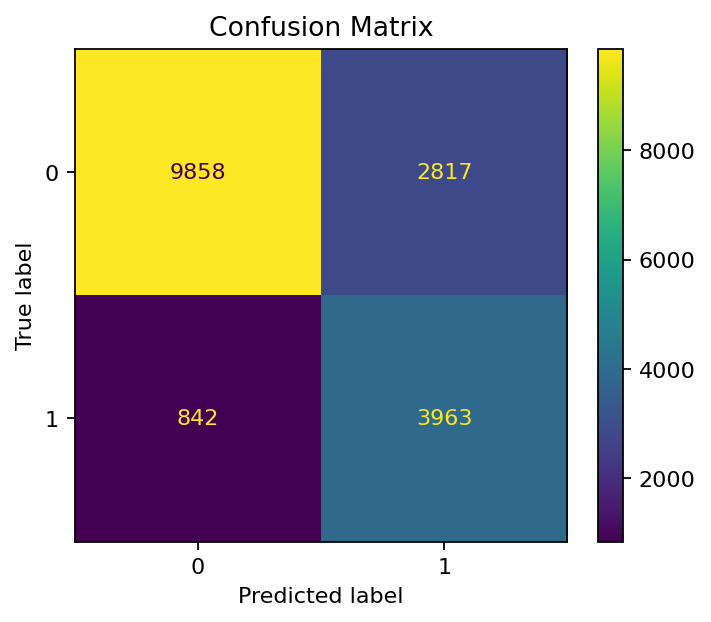

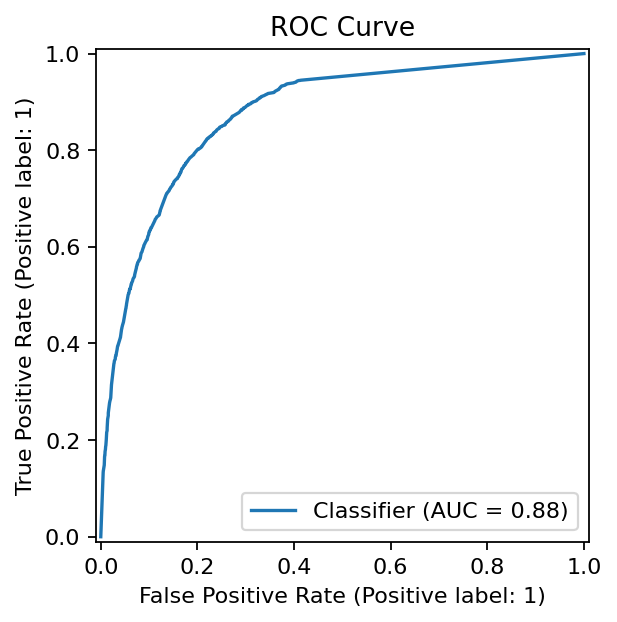

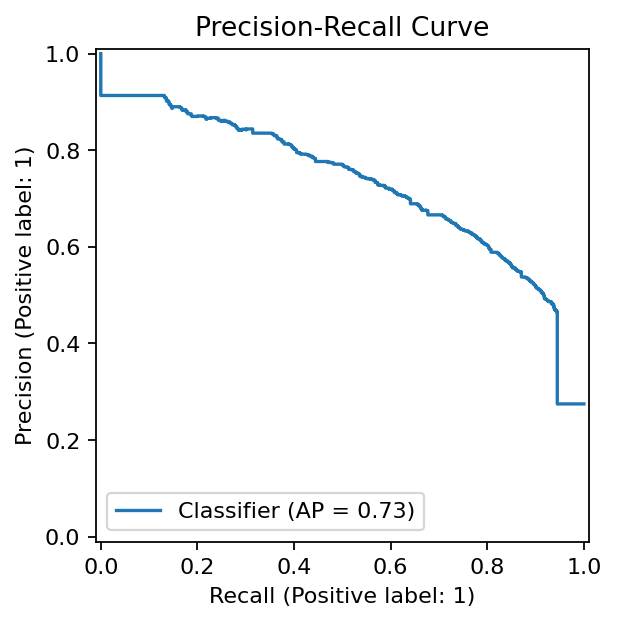

In [11]:
# Plots
# Generates and saves diagnostic visualizations:
# • artifacts/plots/dt_confusion_matrix.png
# • artifacts/plots/dt_roc_curve.png (if proba available)
# • artifacts/plots/dt_pr_curve.png (if proba available)

plot_confusion_matrix(
    y_test,
    y_pred,
    out_path=ART["plots"] / f"{MODEL_NAME}_confusion_matrix.png",
    dpi=FIG_DPI,
)

if y_proba is not None:
    plot_roc_curve(
        y_test,
        y_proba,
        out_path=ART["plots"] / f"{MODEL_NAME}_roc_curve.png",
        dpi=FIG_DPI,
    )
    plot_pr_curve(
        y_test,
        y_proba,
        out_path=ART["plots"] / f"{MODEL_NAME}_pr_curve.png",
        dpi=FIG_DPI,
    )


# Display saved plots inline
from IPython.display import Image, display

print("Saved plots:")
print(f"  • {ART['plots'] / f'{MODEL_NAME}_confusion_matrix.png'}")
if y_proba is not None:
    print(f"  • {ART['plots'] / f'{MODEL_NAME}_roc_curve.png'}")
    print(f"  • {ART['plots'] / f'{MODEL_NAME}_pr_curve.png'}")
print()


# Display with reduced width for better notebook layout
display(Image(filename=ART["plots"] / f"{MODEL_NAME}_confusion_matrix.png", width=400))
if y_proba is not None:
    display(Image(filename=ART["plots"] / f"{MODEL_NAME}_roc_curve.png", width=400))
    display(Image(filename=ART["plots"] / f"{MODEL_NAME}_pr_curve.png", width=400))

## Threshold metrics analysis
Analyzes model performance across different probability thresholds to find optimal operating points.

In [12]:
# Threshold metrics analysis (optional but recommended)
# Evaluate model performance at different probability thresholds

from sklearn.metrics import precision_score, recall_score, f1_score

if y_proba is not None:
    thresholds = np.arange(0.1, 1.0, 0.05)
    threshold_rows = []
    
    for thresh in thresholds:
        y_pred_thresh = (y_proba >= thresh).astype(int)
        threshold_rows.append({
            "threshold": round(thresh, 2),
            "precision": precision_score(y_test, y_pred_thresh, zero_division=0),
            "recall": recall_score(y_test, y_pred_thresh, zero_division=0),
            "f1": f1_score(y_test, y_pred_thresh, zero_division=0),
            "predicted_positive": int(y_pred_thresh.sum()),
            "predicted_negative": int(len(y_pred_thresh) - y_pred_thresh.sum()),
        })
    
    threshold_df = pd.DataFrame(threshold_rows)
    save_dataframe(threshold_df, ART["metrics"] / f"{MODEL_NAME}_threshold_metrics.csv", index=False)
    
    print("Saved:", (ART["metrics"] / f"{MODEL_NAME}_threshold_metrics.csv").resolve())
    display(threshold_df)
    
    # Find optimal threshold by F1
    best_thresh_idx = threshold_df["f1"].idxmax()
    best_thresh = threshold_df.loc[best_thresh_idx]
    print(f"\nOptimal threshold by F1: {best_thresh['threshold']:.2f} (F1={best_thresh['f1']:.4f})")
else:
    print("Threshold analysis skipped: predict_proba not available.")

Saved: D:\Documents\SLIIT_Campus\Y4S2\ML_IT4060\ML_assignment_01\Machine-Learning-Assignment\artifacts\metrics\dt_threshold_metrics.csv


,threshold,precision,recall,f1,predicted_positive,predicted_negative
0,0.10,0.469032,0.940895,0.626004,9639,7841
1,0.15,0.478238,0.937565,0.633392,9420,8060
2,0.20,0.489587,0.924662,0.640202,9075,8405
3,0.25,0.505938,0.913215,0.651135,8673,8807
4,0.30,0.514201,0.904266,0.655602,8450,9030
5,0.35,0.532186,0.887825,0.665471,8016,9464
6,0.40,0.553634,0.859313,0.673408,7458,10022
7,0.45,0.566546,0.845161,0.678360,7168,10312
8,0.50,0.584513,0.824766,0.684161,6780,10700
9,0.55,0.602378,0.801457,0.687801,6393,11087



Optimal threshold by F1: 0.60 (F1=0.6913)


## Feature importance


Feature names count: 0
Importances count: 103
Using generic feature names due to mismatch.
Saved: D:\Documents\SLIIT_Campus\Y4S2\ML_IT4060\ML_assignment_01\Machine-Learning-Assignment\artifacts\metrics\dt_feature_importance.csv
Saved: D:\Documents\SLIIT_Campus\Y4S2\ML_IT4060\ML_assignment_01\Machine-Learning-Assignment\artifacts\plots\dt_feature_importance.png


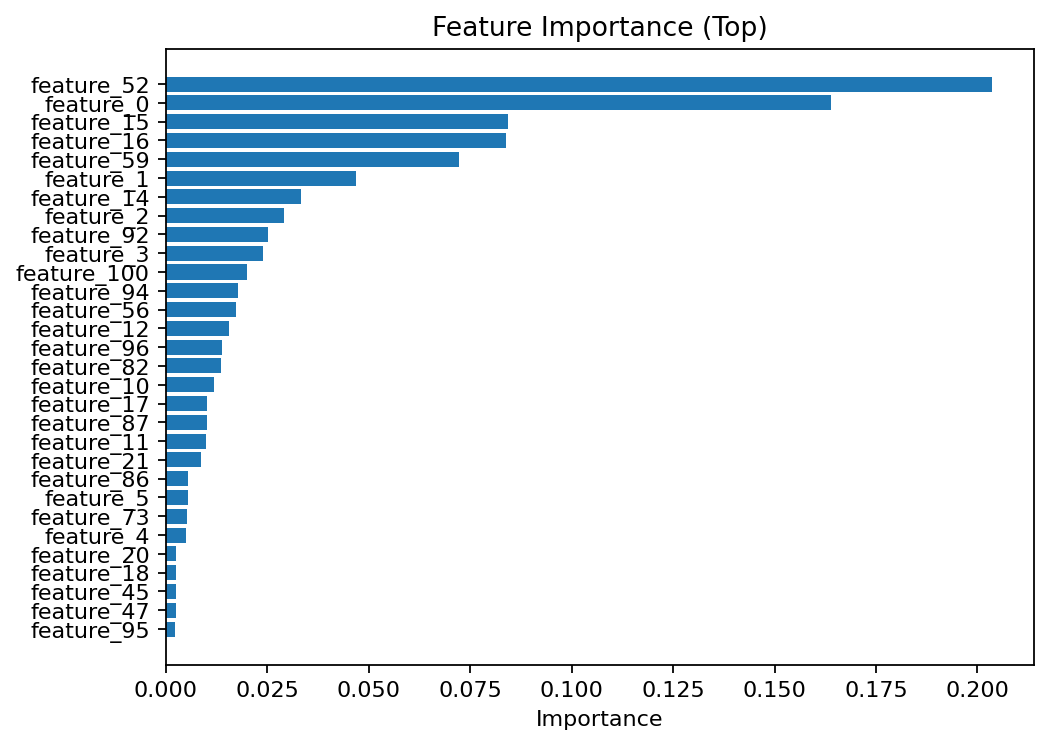

In [13]:
# Feature importance

# Get feature names from the preprocessor
try:
    feature_names = get_feature_names(best_model.named_steps["preprocess"], input_features=X_train.columns)
except Exception as e:
    print(f"Warning: Could not get feature names via get_feature_names: {e}")
    feature_names = None

importances = best_model.named_steps["model"].feature_importances_

# Handle length mismatch between feature names and importances
if feature_names is None or len(feature_names) != len(importances):
    print(f"Feature names count: {len(feature_names) if feature_names is not None else 'N/A'}")
    print(f"Importances count: {len(importances)}")
    print("Using generic feature names due to mismatch.")
    feature_names = [f"feature_{i}" for i in range(len(importances))]

fi_df = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

save_dataframe(fi_df, ART["metrics"] / f"{MODEL_NAME}_feature_importance.csv", index=False)

# Plot feature importance
plot_feature_importance(
    model=best_model.named_steps["model"],
    feature_names=feature_names,
    top_n=30,
    out_path=ART["plots"] / f"{MODEL_NAME}_feature_importance.png",
    dpi=FIG_DPI,
)

print("Saved:", (ART["metrics"] / f"{MODEL_NAME}_feature_importance.csv").resolve())
print("Saved:", (ART["plots"] / f"{MODEL_NAME}_feature_importance.png").resolve())

fi_df.head(15)

display(Image(filename=ART["plots"] / f"{MODEL_NAME}_feature_importance.png", width=400))


## Save fitted pipeline


In [16]:
# Save fitted pipeline
save_model(best_model, ART["models"] / f"{MODEL_NAME}_pipeline.joblib")
print("Saved:", (ART["models"] / f"{MODEL_NAME}_pipeline.joblib").resolve())

Saved: D:\Documents\SLIIT_Campus\Y4S2\ML_IT4060\ML_assignment_01\Machine-Learning-Assignment\artifacts\models\dt_pipeline.joblib


## Model notes and summary
Generates a comprehensive markdown report documenting model decisions, hyperparameters, and outcomes.

In [17]:
# Generate and save dt_notes.md report

notes_content = f"""# Decision Tree Model Notes

## Model Overview
- **Algorithm**: Decision Tree Classifier (CART)
- **Task**: Binary classification (hotel booking cancellation prediction)
- **Target Variable**: `{TARGET_COL}`

## Data
- **Dataset**: `{dataset_path.name}`
- **Total samples**: {len(df_model):,}
- **Train samples**: {len(X_train):,}
- **Test samples**: {len(X_test):,}
- **Test size**: {TEST_SIZE * 100:.0f}%
- **Stratified split**: Yes

## Preprocessing
- **Leakage columns dropped**: {', '.join(LEAKAGE_COLS)}
- **Categorical encoding**: One-hot (min_frequency={ONEHOT_MIN_FREQUENCY})
- **Numeric scaling**: StandardScaler (applied via shared pipeline)
- **Note**: Decision Trees don't require scaling, but using unified pipeline for consistency

## Hyperparameter Tuning
- **Method**: GridSearchCV with {CV_SPLITS}-fold stratified cross-validation
- **Scoring metric**: F1 score
- **Parameters tuned**:
  - `max_depth`: {param_grid.get('model__max_depth', 'N/A')}
  - `min_samples_split`: {param_grid.get('model__min_samples_split', 'N/A')}
  - `min_samples_leaf`: {param_grid.get('model__min_samples_leaf', 'N/A')}
  - `class_weight`: {param_grid.get('model__class_weight', 'N/A')}

## Best Hyperparameters
```json
{json.dumps(search.best_params_, indent=2)}
```

## Cross-Validation Results
- **Best CV F1 Score**: {search.best_score_:.4f}

## Test Set Performance
| Metric            | Value              |
|-------------------|--------------------|
| Accuracy          | {test_metrics.get('accuracy', 'N/A'):.4f}             |
| Balanced Accuracy | {test_metrics.get('balanced_accuracy', 'N/A'):.4f}             |
| Precision         | {test_metrics.get('precision', 'N/A'):.4f}             |
| Recall            | {test_metrics.get('recall', 'N/A'):.4f}             |
| F1 Score          | {test_metrics.get('f1', 'N/A'):.4f}             |
| ROC-AUC           | {test_metrics.get('roc_auc', 'N/A') if isinstance(test_metrics.get('roc_auc'), float) else 'N/A'} |
| PR-AUC            | {test_metrics.get('pr_auc', 'N/A') if isinstance(test_metrics.get('pr_auc'), float) else 'N/A'} |
| Log Loss          | {test_metrics.get('log_loss', 'N/A') if isinstance(test_metrics.get('log_loss'), float) else 'N/A'} |

## Key Observations
1. **Tree Depth**: The optimal `max_depth` balances model complexity with generalization
2. **Class Imbalance**: `class_weight='balanced'` may improve recall for minority class
3. **Interpretability**: Feature importance provides clear insight into predictive factors

## Top 5 Important Features
{fi_df.head(5).to_markdown(index=False)}

## Artifacts Generated
- Model: `artifacts/models/{MODEL_NAME}_pipeline.joblib`
- Metrics: `artifacts/metrics/{MODEL_NAME}_*.json/csv`
- Plots: `artifacts/plots/{MODEL_NAME}_*.png`
- Reports: `artifacts/reports/{MODEL_NAME}_*.txt/md`

## Notes
- Random state: {RANDOM_STATE} (for reproducibility)
- Run date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

save_text(notes_content, ART["reports"] / f"{MODEL_NAME}_notes.md")
print("Saved:", (ART["reports"] / f"{MODEL_NAME}_notes.md").resolve())

Saved: D:\Documents\SLIIT_Campus\Y4S2\ML_IT4060\ML_assignment_01\Machine-Learning-Assignment\artifacts\reports\dt_notes.md


## Optional: depth vs F1 diagnostic (quick sweep)


Saved: D:\Documents\SLIIT_Campus\Y4S2\ML_IT4060\ML_assignment_01\Machine-Learning-Assignment\artifacts\plots\dt_tree_depth_vs_f1.png


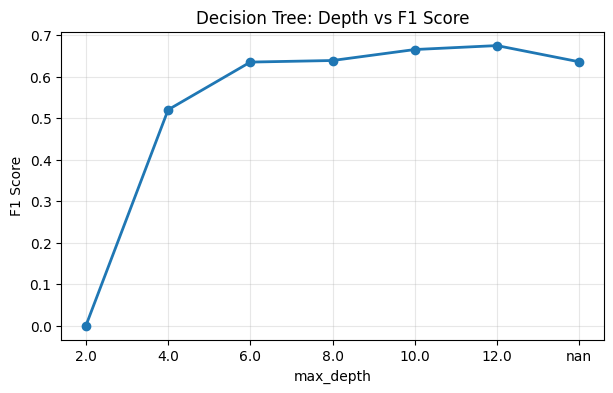

,max_depth,f1
0,2.0,0.000000
1,4.0,0.520025
2,6.0,0.634897
3,8.0,0.638687
4,10.0,0.665129
5,12.0,0.674650
6,NaN,0.635606


In [18]:
# Optional: depth vs F1 diagnostic (quick sweep)
depths = [2, 4, 6, 8, 10, 12, None]
rows = []
for d in depths:
    est = get_estimator("decision_tree", random_state=RANDOM_STATE)
    est.set_params(max_depth=d)
    pipe = build_model_pipeline(preprocess, est)
    pipe.fit(X_train, y_train)
    y_hat = pipe.predict(X_test)
    rows.append({"max_depth": d, "f1": compute_classification_metrics(y_test, y_hat)["f1"]})

depth_f1_df = pd.DataFrame(rows)
save_dataframe(depth_f1_df, ART["metrics"] / f"{MODEL_NAME}_tree_depth_vs_f1.csv", index=False)
depth_f1_df


depth_f1_df = pd.DataFrame(rows)
save_dataframe(depth_f1_df, ART["metrics"] / f"{MODEL_NAME}_tree_depth_vs_f1.csv", index=False)

# Add plot generation
fig, ax = plt.subplots(figsize=(7, 4))
x_labels = [str(d) if d is not None else "None" for d in depth_f1_df["max_depth"]]
ax.plot(x_labels, depth_f1_df["f1"], marker="o", linewidth=2)
ax.set_xlabel("max_depth")
ax.set_ylabel("F1 Score")
ax.set_title("Decision Tree: Depth vs F1 Score")
ax.grid(True, alpha=0.3)

# Save plot
plot_path = ART["plots"] / f"{MODEL_NAME}_tree_depth_vs_f1.png"
fig.savefig(plot_path, dpi=FIG_DPI, bbox_inches="tight")
print("Saved:", plot_path.resolve())

plt.show()
plt.close(fig)

depth_f1_df

## Decision Tree Visualization

Visualizes the structure of the trained decision tree. Limited to a specific depth for readability.

DECISION TREE STRUCTURE (Text)
|--- feature_0 <= -0.84
|   |--- feature_15 <= 1.50
|   |   |--- feature_0 <= -0.93
|   |   |   |--- feature_52 <= 0.50
|   |   |   |   |--- feature_94 <= 0.50
|   |   |   |   |   |--- feature_85 <= 0.50
|   |   |   |   |   |   |--- truncated branch of depth 11
|   |   |   |   |   |--- feature_85 >  0.50
|   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |--- feature_94 >  0.50
|   |   |   |   |   |--- feature_14 <= -0.53
|   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |--- feature_14 >  -0.53
|   |   |   |   |   |   |--- truncated branch of depth 12
|   |   |   |--- feature_52 >  0.50
|   |   |   |   |--- feature_11 <= 0.65
|   |   |   |   |   |--- feature_12 <= 0.40
|   |   |   |   |   |   |--- truncated branch of depth 15
|   |   |   |   |   |--- feature_12 >  0.40
|   |   |   |   |   |   |--- truncated branch of depth 7
|   |   |   |   |--- feature_11 >  0.65
|   |   |   |   |   |--- feature_34 <= 0.5

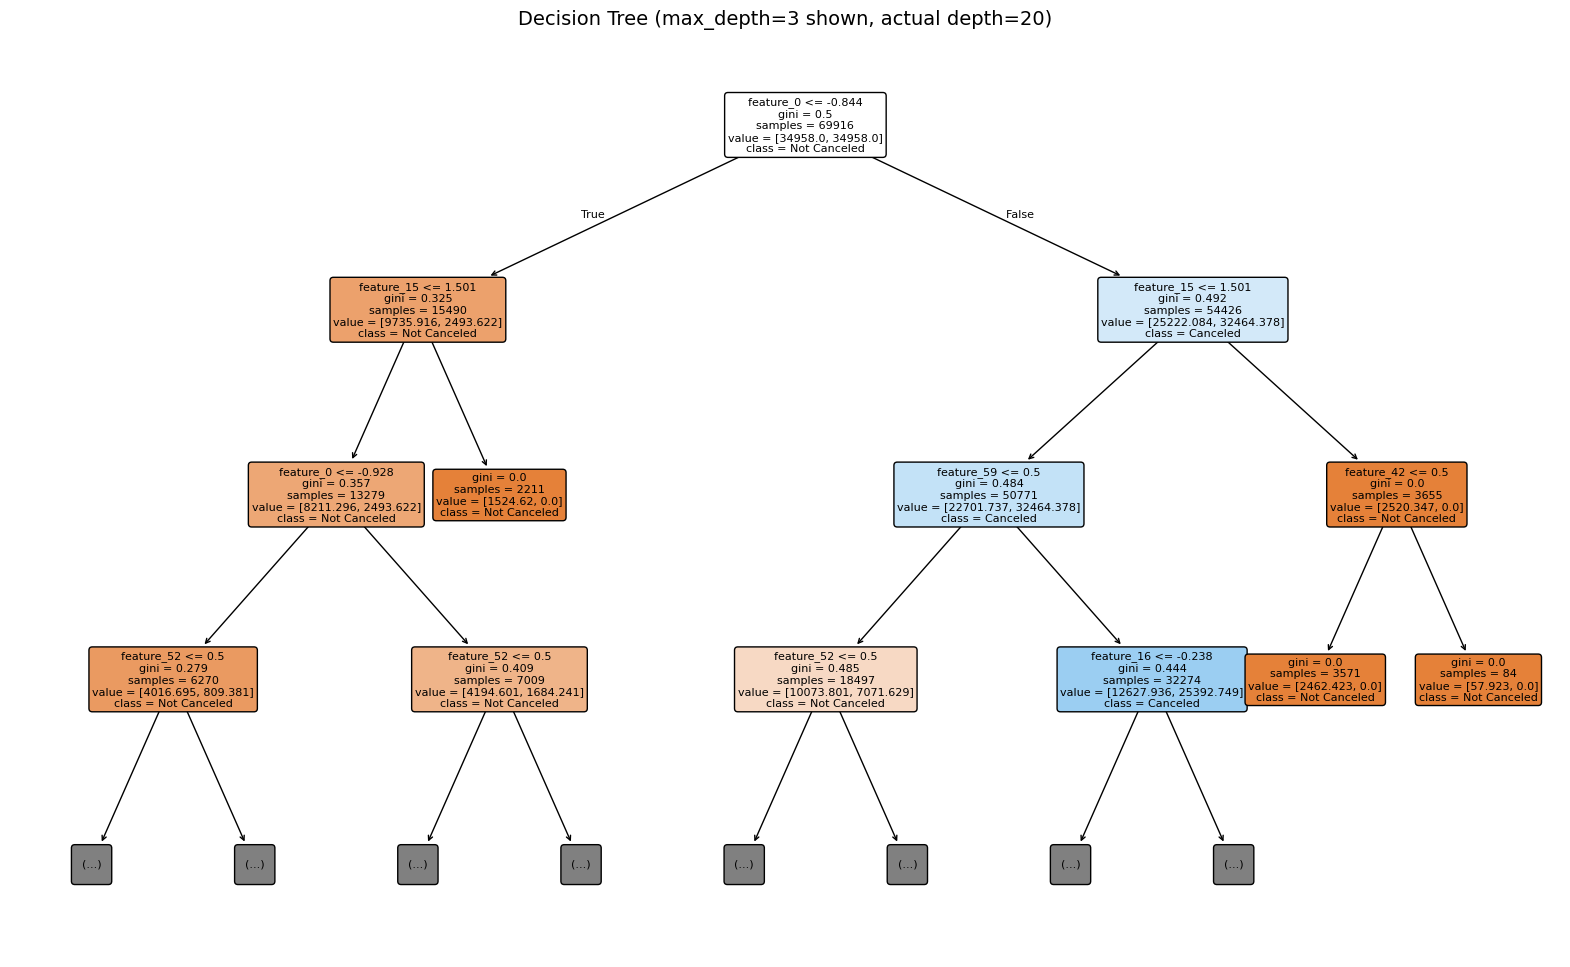


DECISION TREE STATISTICS
Tree depth:        20
Number of leaves:  1675
Number of features used: 103


In [19]:
# Decision Tree Visualization

from sklearn.tree import plot_tree, export_text

# Get the trained decision tree model
dt_model = best_model.named_steps["model"]

# Option 1: Text representation (always works)
print("=" * 50)
print("DECISION TREE STRUCTURE (Text)")
print("=" * 50)
tree_text = export_text(
    dt_model, 
    feature_names=feature_names if len(feature_names) == dt_model.n_features_in_ else None,
    max_depth=5,  # Limit depth for readability
)
print(tree_text[:3000])  # Print first 3000 chars to avoid overwhelming output
if len(tree_text) > 3000:
    print("... (truncated)")

# Option 2: Graphical visualization
fig, ax = plt.subplots(figsize=(20, 12))
plot_tree(
    dt_model,
    feature_names=feature_names if len(feature_names) == dt_model.n_features_in_ else None,
    class_names=["Not Canceled", "Canceled"],
    filled=True,
    rounded=True,
    max_depth=3,  # Limit depth for visualization clarity
    fontsize=8,
    ax=ax,
)
ax.set_title(f"Decision Tree (max_depth=3 shown, actual depth={dt_model.get_depth()})", fontsize=14)

# Save the tree visualization
tree_plot_path = ART["plots"] / f"{MODEL_NAME}_tree_structure.png"
fig.savefig(tree_plot_path, dpi=FIG_DPI, bbox_inches="tight", facecolor="white")
print(f"\nSaved: {tree_plot_path.resolve()}")

plt.show()
plt.close(fig)

# Display tree statistics
print("\n" + "=" * 50)
print("DECISION TREE STATISTICS")
print("=" * 50)
print(f"Tree depth:        {dt_model.get_depth()}")
print(f"Number of leaves:  {dt_model.get_n_leaves()}")
print(f"Number of features used: {dt_model.n_features_in_}")

In [20]:
# Full decision tree visualization (larger, for detailed analysis)

# Only generate if tree is not too deep
if dt_model.get_depth() <= 10:
    fig_full, ax_full = plt.subplots(figsize=(30, 20))
    plot_tree(
        dt_model,
        feature_names=feature_names if len(feature_names) == dt_model.n_features_in_ else None,
        class_names=["Not Canceled", "Canceled"],
        filled=True,
        rounded=True,
        max_depth=5,  # Show more depth
        fontsize=6,
        ax=ax_full,
    )
    ax_full.set_title(f"Decision Tree (Full Structure, depth={dt_model.get_depth()})", fontsize=14)
    
    tree_full_path = ART["plots"] / f"{MODEL_NAME}_tree_structure_full.png"
    fig_full.savefig(tree_full_path, dpi=200, bbox_inches="tight", facecolor="white")
    print(f"Saved: {tree_full_path.resolve()}")
    
    plt.show()
    plt.close(fig_full)
else:
    print(f"Tree too deep ({dt_model.get_depth()} levels) for full visualization.")
    print("Use the limited-depth visualization above.")

Tree too deep (20 levels) for full visualization.
Use the limited-depth visualization above.


## Verify all expected artifacts exist


In [21]:
# Verify all expected artifacts exist

paths = [
    ART["models"] / f"{MODEL_NAME}_pipeline.joblib",
    ART["metrics"] / f"{MODEL_NAME}_cv_results.csv",
    ART["metrics"] / f"{MODEL_NAME}_best_params.json",
    ART["metrics"] / f"{MODEL_NAME}_test_metrics.json",
    ART["metrics"] / f"{MODEL_NAME}_threshold_metrics.csv",
    ART["metrics"] / f"{MODEL_NAME}_feature_importance.csv",
    ART["metrics"] / f"{MODEL_NAME}_tree_depth_vs_f1.csv",
    ART["plots"] / f"{MODEL_NAME}_confusion_matrix.png",
    ART["plots"] / f"{MODEL_NAME}_roc_curve.png",
    ART["plots"] / f"{MODEL_NAME}_pr_curve.png",
    ART["plots"] / f"{MODEL_NAME}_feature_importance.png",
    ART["plots"] / f"{MODEL_NAME}_tree_depth_vs_f1.png",
    ART["plots"] / f"{MODEL_NAME}_tree_structure.png",
    ART["reports"] / f"{MODEL_NAME}_classification_report.txt",
    ART["reports"] / f"{MODEL_NAME}_notes.md",
]

artifact_status = pd.DataFrame([{"path": str(p), "exists": p.exists()} for p in paths])
display(artifact_status)

# Summary
missing = artifact_status[~artifact_status["exists"]]
if missing.empty:
    print(f"\n✅ All {len(paths)} artifacts generated successfully!")
else:
    print(f"\n⚠️ Missing {len(missing)} artifact(s):")
    for p in missing["path"]:
        print(f"   • {p}")

,path,exists
0,artifacts\models\dt_pipeline.joblib,True
1,artifacts\metrics\dt_cv_results.csv,True
2,artifacts\metrics\dt_best_params.json,True
3,artifacts\metrics\dt_test_metrics.json,True
4,artifacts\metrics\dt_threshold_metrics.csv,True
5,artifacts\metrics\dt_feature_importance.csv,True
6,artifacts\metrics\dt_tree_depth_vs_f1.csv,True
7,artifacts\plots\dt_confusion_matrix.png,True
8,artifacts\plots\dt_roc_curve.png,True
9,artifacts\plots\dt_pr_curve.png,True



✅ All 15 artifacts generated successfully!


## Results Discussion (Decision Tree)

This section summarizes the outcomes from the trained Decision Tree model and provides report-ready interpretations.

### Key points to include in the report:

#### 1. Cross-validation Performance
The best configuration is selected using mean cross-validated **F1 score**. Report:
- Best mean CV F1 (and standard deviation)
- Selected hyperparameters (`max_depth`, `min_samples_split`, `min_samples_leaf`, `class_weight`)
- Brief justification for using F1 (balances precision and recall under class imbalance)

#### 2. Test-set Performance
Report the test metrics saved in `artifacts/metrics/dt_test_metrics.json`:
- F1, Precision, Recall, Balanced Accuracy
- ROC-AUC and PR-AUC (probability-based discrimination)
- Log loss (probability calibration check, lower is better)

#### 3. Error Profile (Confusion Matrix)
Use the saved confusion matrix plot to describe:
- Whether the model produces more false positives or false negatives
- Why that outcome matters for hotel cancellations:
  - **False Positives** (predict cancel, actually stayed): May lead to unnecessary overbooking
  - **False Negatives** (predict stay, actually canceled): May lead to revenue loss from empty rooms

#### 4. Threshold Analysis
If `artifacts/metrics/dt_threshold_metrics.csv` is available:
- Identify the threshold that maximizes F1 (or another objective chosen for the project)
- Describe the precision–recall trade-off when moving the threshold
- Justify whether the default threshold (0.50) is appropriate

#### 5. Interpretability (Feature Importance)
Use the feature importance tables and plots to describe:
- **Top features** by Gini importance (features most influential in splitting decisions)
- **Business interpretation**: What do these features tell us about cancellation behavior?
- **Limitation**: Feature importance shows predictive power, not causal relationships

#### 6. Tree Structure Analysis
From the tree visualization:
- Report the optimal tree depth and number of leaves
- Describe the top-level splits (most important decisions)
- Discuss interpretability advantage of Decision Trees over black-box models

#### 7. Model Limitations and Next Steps

**Limitations:**
1. Decision Trees are prone to **overfitting** if not properly regularized (controlled via `max_depth`, `min_samples_leaf`)
2. **Axis-aligned splits** may miss diagonal decision boundaries
3. **High variance**: Small changes in data can produce very different trees
4. **Greedy algorithm**: Locally optimal splits may not be globally optimal





In [22]:
# Auto-summary table (generated from saved artifacts)
# This cell loads the saved metrics and produces a compact report-ready summary.

import json
from pathlib import Path
import pandas as pd

metrics_path = ART["metrics"] / f"{MODEL_NAME}_test_metrics.json"
best_params_path = ART["metrics"] / f"{MODEL_NAME}_best_params.json"
cv_path = ART["metrics"] / f"{MODEL_NAME}_cv_results.csv"
thr_path = ART["metrics"] / f"{MODEL_NAME}_threshold_metrics.csv"
fi_path = ART["metrics"] / f"{MODEL_NAME}_feature_importance.csv"

summary = {}

if best_params_path.exists():
    summary["best_params"] = json.loads(best_params_path.read_text(encoding="utf-8"))

if metrics_path.exists():
    summary["test_metrics"] = json.loads(metrics_path.read_text(encoding="utf-8"))

if cv_path.exists():
    cv_df = pd.read_csv(cv_path)
    # Find the best row by mean_test_score (GridSearchCV format)
    if "mean_test_score" in cv_df.columns:
        best_idx = cv_df["mean_test_score"].idxmax()
        summary["best_cv_f1_mean"] = cv_df.loc[best_idx, "mean_test_score"]
        summary["best_cv_f1_std"] = cv_df.loc[best_idx, "std_test_score"]
    elif "cv_f1_mean" in cv_df.columns:
        best_idx = cv_df["cv_f1_mean"].idxmax()
        summary["best_cv_f1_mean"] = cv_df.loc[best_idx, "cv_f1_mean"]
        summary["best_cv_f1_std"] = cv_df.loc[best_idx, "cv_f1_std"]

print("=" * 60)
print("DECISION TREE MODEL SUMMARY")
print("=" * 60)

display(pd.DataFrame([{
    "best_cv_f1_mean": summary.get("best_cv_f1_mean", None),
    "best_cv_f1_std": summary.get("best_cv_f1_std", None),
    "test_f1": summary.get("test_metrics", {}).get("f1", None),
    "test_precision": summary.get("test_metrics", {}).get("precision", None),
    "test_recall": summary.get("test_metrics", {}).get("recall", None),
    "test_balanced_accuracy": summary.get("test_metrics", {}).get("balanced_accuracy", None),
    "test_roc_auc": summary.get("test_metrics", {}).get("roc_auc", None),
    "test_pr_auc": summary.get("test_metrics", {}).get("pr_auc", None),
    "test_log_loss": summary.get("test_metrics", {}).get("log_loss", None),
}]).T.rename(columns={0: "Value"}))

print("\nBest Hyperparameters:")
if "best_params" in summary:
    display(pd.DataFrame([summary["best_params"]]).T.rename(columns={0: "Value"}))

if thr_path.exists():
    thr_df = pd.read_csv(thr_path)
    best_thr = thr_df.sort_values("f1", ascending=False).iloc[0].to_dict()
    print("\nOptimal Threshold Analysis:")
    display(pd.DataFrame([{
        "best_threshold_by_f1": best_thr.get("threshold"),
        "precision_at_best_threshold": best_thr.get("precision"),
        "recall_at_best_threshold": best_thr.get("recall"),
        "f1_at_best_threshold": best_thr.get("f1"),
    }]).T.rename(columns={0: "Value"}))
else:
    print("\nThreshold metrics file not found. Threshold analysis may have been skipped.")

if fi_path.exists():
    fi_df = pd.read_csv(fi_path)
    print("\nTop 10 Important Features:")
    display(fi_df.head(10))

DECISION TREE MODEL SUMMARY


,Value
best_cv_f1_mean,0.684299
best_cv_f1_std,0.004957
test_f1,0.684161
test_precision,0.584513
test_recall,0.824766
test_balanced_accuracy,0.801259
test_roc_auc,0.875145
test_pr_auc,0.728146
test_log_loss,1.036469



Best Hyperparameters:


,Value
model__class_weight,balanced
model__max_depth,20
model__min_samples_leaf,10
model__min_samples_split,30



Optimal Threshold Analysis:


,Value
best_threshold_by_f1,0.600000
precision_at_best_threshold,0.628620
recall_at_best_threshold,0.767950
f1_at_best_threshold,0.691335



Top 10 Important Features:


,feature,importance
0,feature_52,0.203630
1,feature_0,0.163997
2,feature_15,0.084261
3,feature_16,0.083882
4,feature_59,0.072202
5,feature_1,0.046880
6,feature_14,0.033338
7,feature_2,0.029203
8,feature_92,0.025301
9,feature_3,0.024047
